In [1]:
import numpy as np

import tensorflow as tf

from PIL import Image as Img
import os

import mtcnn

from matplotlib import pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

my_image_path = "../../faces/"
dataset_image_path = "../../../Dataset/data/lfw/"
image_files = [f for f in os.listdir(my_image_path) if f[-5:] != '2.jpg']

In [2]:
tf_lite_model = tf.lite.Interpreter(model_path='../../tflite/facenet.tflite')
tf_lite_model.allocate_tensors()

input_details = tf_lite_model.get_input_details()
output_details = tf_lite_model.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  1 160 160   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [  1 512]
type: <class 'numpy.float32'>


In [3]:
def get_image_embedding(image_path, tf_lite_model):
    # Open image
    image = Img.open(image_path).convert('RGB')
    pixels = np.asarray(image)
    # detect faces in the image
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    if len(results) != 1:
        return np.array([])
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Img.fromarray(face)
    image = image.resize((160, 160))
    face_array = np.asarray(image)
    face_array_norm = face_array /255
    
    input_details = tf_lite_model.get_input_details()
    output_details = tf_lite_model.get_output_details()

    tf_lite_model.set_tensor(input_details[0]['index'], face_array_norm.reshape(1,160,160,3).astype(np.float32))
    tf_lite_model.invoke()

    return tf_lite_model.get_tensor(output_details[0]['index'])

In [4]:
embedding = get_image_embedding(dataset_image_path+'Park_Jie-won/Park_Jie-won_0001.jpg', tf_lite_model)

#print([ "{:0.8f}".format(x) for x in embedding[0] ])

In [5]:
embedding.shape

(0,)

In [70]:
person_1 = my_image_path+'WindersonNunes2.jpg'
person_2 = my_image_path+'Pericles2.jpg'

In [71]:
embedding_1 = get_image_embedding(person_1, tf_lite_model)
embedding_2 = get_image_embedding(person_2, tf_lite_model)

if embedding_1.shape == (1, 512) and embedding_2.shape == (1, 512):
    dist = np.linalg.norm(embedding_1 - embedding_2)
    print(dist)
else:
    print("embedding_1: ", embedding_1.shape)
    print("embedding_2: ", embedding_2.shape)

1.418081


In [67]:
dist

0.6176745

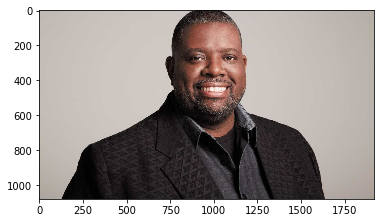

In [68]:
image = Img.open(person_1).convert('RGB')
pixels = np.asarray(image)

plt.imshow(pixels, interpolation='nearest')
plt.show()

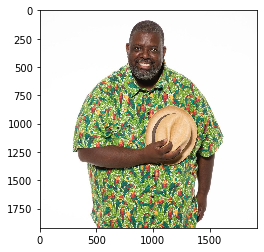

In [69]:
image = Img.open(person_2).convert('RGB')
pixels = np.asarray(image)

plt.imshow(pixels, interpolation='nearest')
plt.show()